In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from mpl_toolkits.basemap import Basemap
from math import pi as PI

#mapbox_access_token = 'pk.eyJ1IjoiY2hlbHNlYXBsb3RseSIsImEiOiJjaXFqeXVzdDkwMHFrZnRtOGtlMGtwcGs4In0.SLidkdBMEap9POJGIe1eGw'

## Stations

In [36]:
stations = pd.read_csv('data/station.csv')

In [37]:
stations['date'] = pd.to_datetime(stations['installation_date'])
del(stations['installation_date'])

In [4]:
#stations

## Trips

In [38]:
trips = pd.read_csv('data/trip.csv')

In [6]:
#trips.sample(3)

Viendo algunos datos, podemos hacer una limpieza del dataframe.

Por ejemplo, no nos interesan los zip codes y se puede cambiar el formato de las fechas (porque a nadie le gusta el formato mm/dd/yyyy y ademas, el estandar ISO 8601 existe por algun motivo)

In [39]:
del(trips['zip_code'])

In [40]:
trips['start_date'] = pd.to_datetime(trips['start_date'], format='%m/%d/%Y %H:%M')
trips['end_date'] = pd.to_datetime(trips['end_date'], format='%m/%d/%Y %H:%M')

A continuacion, se quiere obtener un ranking de estaciones por uso:

1. por año
- por todos los años juntos
- 

Ordeno los viajes por id.

In [41]:
trips = trips.sort_values(by='id')

### Subscriptores vs Clientes

subs = trips[trips['subscription_type']=='Subscriber'].count()['id']
cust = trips[trips['subscription_type']=='Customer'].count()['id']

labels = 'Subscribers', 'Customers'
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)

plt.pie([subs, cust], explode=explode, labels=labels, autopct='%1.1f%%', startangle=25, colors=colors)
 
plt.axis('equal')
plt.show()

### Ranking total

trips.groupby('start_station_name')['id'].count().sort_values(ascending=False)[:5].plot(kind='bar');#,figsize=(20,5));
trips.groupby('start_station_name')['id'].count().sort_values(ascending=True)[:5].sort_values(ascending=False).plot(kind='bar');#,figsize=(20,5));

Separo los dataframes por año.

trips_2013 = trips[(trips['start_date'] < '2014')].reset_index()
trips_2014 = trips[('2014' < trips['start_date']) & (trips['start_date'] < '2015')].reset_index()
trips_2015 = trips['2015' < trips['start_date']].reset_index()

### Ranking 2013

trips_2013.groupby('start_station_name')['id'].count().sort_values(ascending=False)[:5].plot(kind='bar',figsize=(20,5));
trips_2013.groupby('start_station_name')['id'].count().sort_values(ascending=True)[:5].plot(kind='bar',figsize=(20,5));

### Ranking 2014

trips_2014.groupby('start_station_name')['id'].count().sort_values(ascending=False)[:5].plot(kind='bar',figsize=(20,5));
trips_2014.groupby('start_station_name')['id'].count().sort_values(ascending=True)[:5].plot(kind='bar',figsize=(20,5));

### Ranking 2015

trips_2015.groupby('start_station_name')['id'].count().sort_values(ascending=False)[:5].plot(kind='bar',figsize=(20,5));
trips_2015.groupby('start_station_name')['id'].count().sort_values(ascending=True)[:5].plot(kind='bar',figsize=(20,5));

## Bicicletas veteranas

Podio de las bicicletas mas utilizadas

trips.groupby('bike_id').count()['index'].sort_values(ascending=False)[:3]#.plot(kind='bar',figsize=(20,5))

2013

trips_2013.groupby('bike_id').count()['index'].sort_values(ascending=False)[:3]

trips_2013['start_date'].max()-trips_2013['start_date'].min()

2014

trips_2014.groupby('bike_id').count()['index'].sort_values(ascending=False)[:3]

trips_2014['start_date'].max()-trips_2014['start_date'].min()

2015

trips_2015.groupby('bike_id').count()['index'].sort_values(ascending=False)[:3]

trips_2015['start_date'].max()-trips_2015['start_date'].min()

## Las aventuras de bike_id 392

Grafico a traves del tiempo de la bici 392, indicando estaciones en las que estuvo y por cuanto tiempo.

#trips_392 = trips[['start_station_name','end_station_name','subscription_type','start_date','end_date','duration']]
trips_392 = trips[trips['bike_id'] == 392][['start_station_name','end_station_name','subscription_type','start_date','end_date','duration']]

En orden para plotear las estaciones en donde estuvo la bicicleta, se necesitan:

1. Las estaciones
- Las ubicaciones de las estaciones
- El trayecto de la bicicleta

start_stations_location = stations.loc[:,'name':'long']
start_stations_location.rename(columns={'name':'start_station_name','lat':'start_lat','long':'start_lon'}, inplace=True)

end_stations_location = stations.loc[:,'name':'long']
end_stations_location.rename(columns={'name':'end_station_name','lat':'end_lat','long':'end_lon'}, inplace=True)

trips_392 = pd.merge(trips_392, start_stations_location, on = 'start_station_name')
trips_392 = pd.merge(trips_392, end_stations_location, on = 'end_station_name')

trips_392 = trips_392.sort_values(by = 'start_date')

#trips_392

In [42]:
def distancia_grados(dist, rad):
    '''
    funcion para calcular grados a partir de una distancia
    
    ejemplo:
        si tengo un mapa, unas coordenadas (latitud, longitud) y quiero ver una zona alrededor de esas coordenadas.
        el mapa muestra un area determinada por 2 coordenadas (que hacen un cuadrado)
        como se quiere ver un area centrada en la coordenada inicial hay que calcular un 
            determinado desplazamiento a partir de la coordenada deseada.
        supongamos que quiero ver no mas de 2km de la coordenada deseada, cuales son las coordenadas que delimitan el area a ver?
        
        la funcion toma una distancia (euclidea) y la convierte a grados. (que indican el desplazamiento sobre una esfera, que son las coordenadas)
        (tambien toma el radio de la esfera)
        
        con esos grados resultantes, se los puedo sumar y/o restar a la coordenada inicial y asi obtener las coordenadas finales
    '''
    return (180 * dist) / (rad * PI)

offset = distancia_grados(40,6371)
# convertir 40km a grados. el otro parametro es el radio de la tierra (en km)

total_bikes = trips
bikes = total_bikes.groupby('start_station_id').count()[['start_station_name']].reset_index()
bikes.rename(columns={'start_station_id':'id','start_station_name':'count'}, inplace=True)
station_bikes = pd.merge(stations, bikes, on='id')
del(station_bikes['dock_count'])

## Popularidad de Estaciones

### San Francisco

sf = station_bikes[station_bikes['city'] == 'San Francisco']
del(sf['city'])

sf_lat, sf_lon = sf.mean()[['lat','long']]

offset = distancia_grados(3, 6371)

min_sf_lat = sf_lat - offset
min_sf_lon = sf_lon - offset
max_sf_lat = sf_lat + offset
max_sf_lon = sf_lon + offset

plt.figure(figsize = (20, 20))
sf_mapa = Basemap(projection = 'merc',
               llcrnrlat = min_sf_lat,
               llcrnrlon = min_sf_lon,
               urcrnrlat = max_sf_lat,
               urcrnrlon = max_sf_lon,
               epsg = 4326,
               resolution = 'l'
              )

sf_mapa.scatter(sf[['long']].values, 
                sf[['lat']].values, 
                s = sf[['count']].apply(lambda x:x/40), 
                marker = 'o', 
                c = ['r','g','b']
               )

sf_mapa.arcgisimage(service='World_Street_Map', xpixels = 1000, ypixels = 1000)

plt.show()

### San Jose

sj = station_bikes[station_bikes['city'] == 'San Jose']
del(sj['city'])

sj_lat, sj_lon = sj.mean()[['lat','long']]

offset = distancia_grados(2, 6371)

min_sj_lat = sj_lat - offset
min_sj_lon = sj_lon - offset
max_sj_lat = sj_lat + offset
max_sj_lon = sj_lon + offset

plt.figure(figsize = (20, 20))
sj_mapa = Basemap(projection = 'merc',
               llcrnrlat = min_sj_lat,
               llcrnrlon = min_sj_lon,
               urcrnrlat = max_sj_lat,
               urcrnrlon = max_sj_lon,
               epsg = 4326,
               resolution = 'l'
              )

sj_mapa.scatter(sj[['long']].values, 
                sj[['lat']].values, 
                s = sj[['count']].apply(lambda x:x/40), 
                marker = 'o', 
                c = ['r','g','b']
               )

sj_mapa.arcgisimage(service='World_Street_Map', xpixels = 1000, ypixels = 1000)

plt.show()

### Redwood City, Palo Alto y Moutain View

rw_pa_mv = station_bikes[(station_bikes['city'] != 'San Jose') & (stations['city'] != 'San Francisco')]
del(rw_pa_mv['city'])

rw_pa_mv_lat, rw_pa_mv_lon = rw_pa_mv.mean()[['lat','long']]

offset = distancia_grados(12, 6371)

min_rw_pa_mv_lat = rw_pa_mv_lat - offset
min_rw_pa_mv_lon = rw_pa_mv_lon - offset
max_rw_pa_mv_lat = rw_pa_mv_lat + offset
max_rw_pa_mv_lon = rw_pa_mv_lon + offset

plt.figure(figsize = (20, 20))
rw_pa_mv_mapa = Basemap(projection = 'merc',
               llcrnrlat = min_rw_pa_mv_lat,
               llcrnrlon = min_rw_pa_mv_lon,
               urcrnrlat = max_rw_pa_mv_lat,
               urcrnrlon = max_rw_pa_mv_lon,
               epsg = 4326,
               resolution = 'l'
              )

rw_pa_mv_mapa.scatter(rw_pa_mv[['long']].values, 
                rw_pa_mv[['lat']].values, 
                s = rw_pa_mv[['count']].apply(lambda x:x/10), 
                marker = 'o', 
                c = ['r','g','b']
               )

rw_pa_mv_mapa.arcgisimage(service='World_Street_Map', xpixels = 1000, ypixels = 1000)

plt.show()

### Toda la bahía

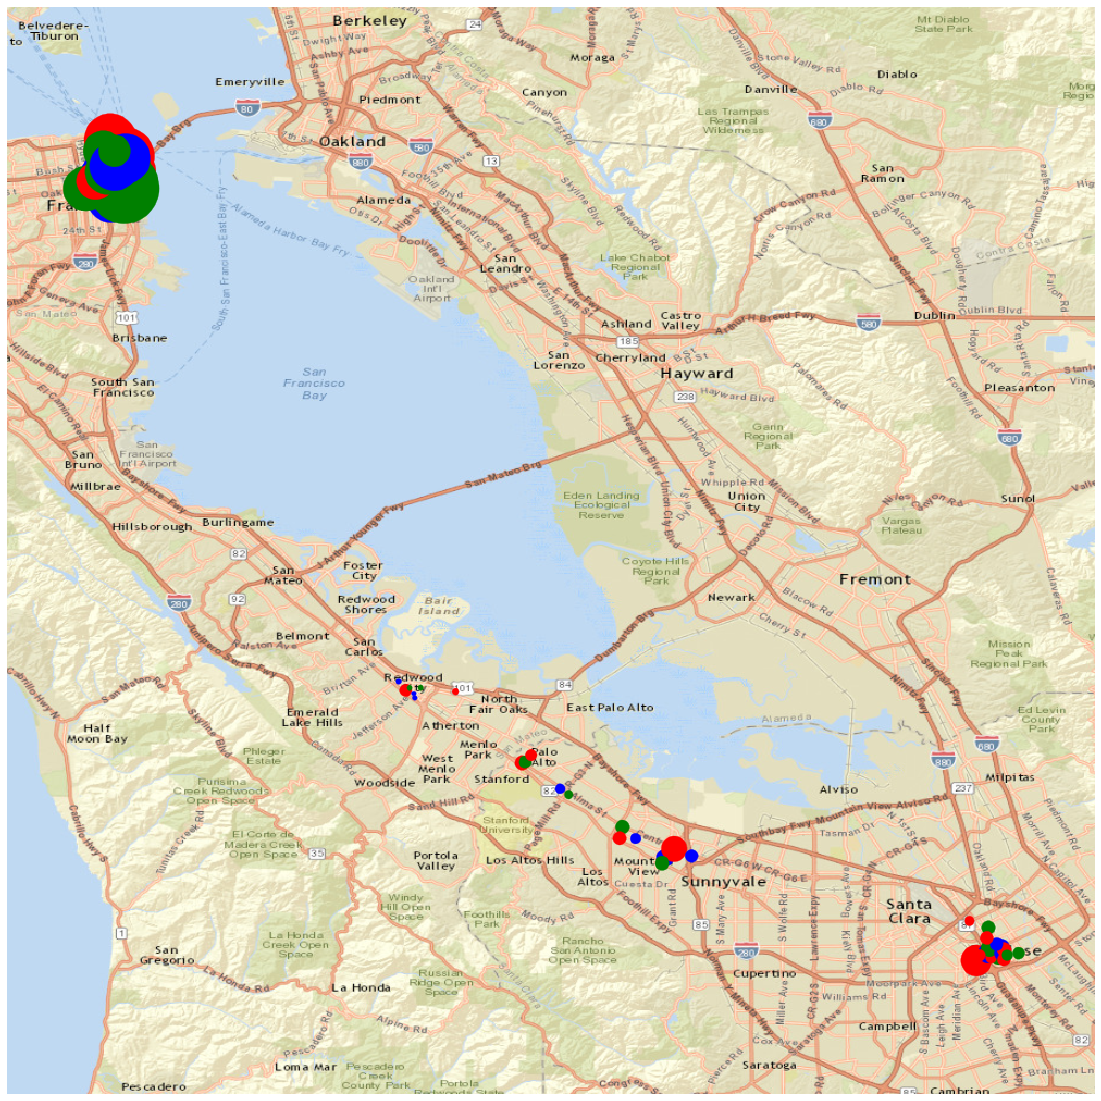

In [50]:
lat_max, lon_max = station_bikes.max()[['lat','long']]
lat_min, lon_min = station_bikes.min()[['lat','long']]
lat, lon = (lat_max+lat_min)/2, (lon_max+lon_min)/2

offset = distancia_grados(35, 6371)

min_lat = lat - offset
min_lon = lon - offset
max_lat = lat + offset
max_lon = lon + offset

plt.figure(figsize = (20, 20))

mapa = Basemap(projection = 'merc',
               llcrnrlat = min_lat,
               llcrnrlon = min_lon,
               urcrnrlat = max_lat,
               urcrnrlon = max_lon,
               epsg = 4326,
               resolution = 'l'
              )

mapa.scatter(station_bikes[['long']].values, 
             station_bikes[['lat']].values,
             s = station_bikes[['count']].apply(lambda x:x/10),
             marker = 'o', 
             c = ['r','g','b']
            )

mapa.arcgisimage(service = 'World_Street_Map', xpixels = 1000, ypixels = 1000)

plt.show()

In [106]:
san_jose = station_bikes[station_bikes['city'] == 'San Jose']
san_fran = station_bikes[station_bikes['city'] == 'San Francisco']
redwood = station_bikes[station_bikes['city'] == 'Redwood City']
mt_view = station_bikes[station_bikes['city'] == 'Mountain View']
palo_alto = station_bikes[station_bikes['city'] == 'Palo Alto']

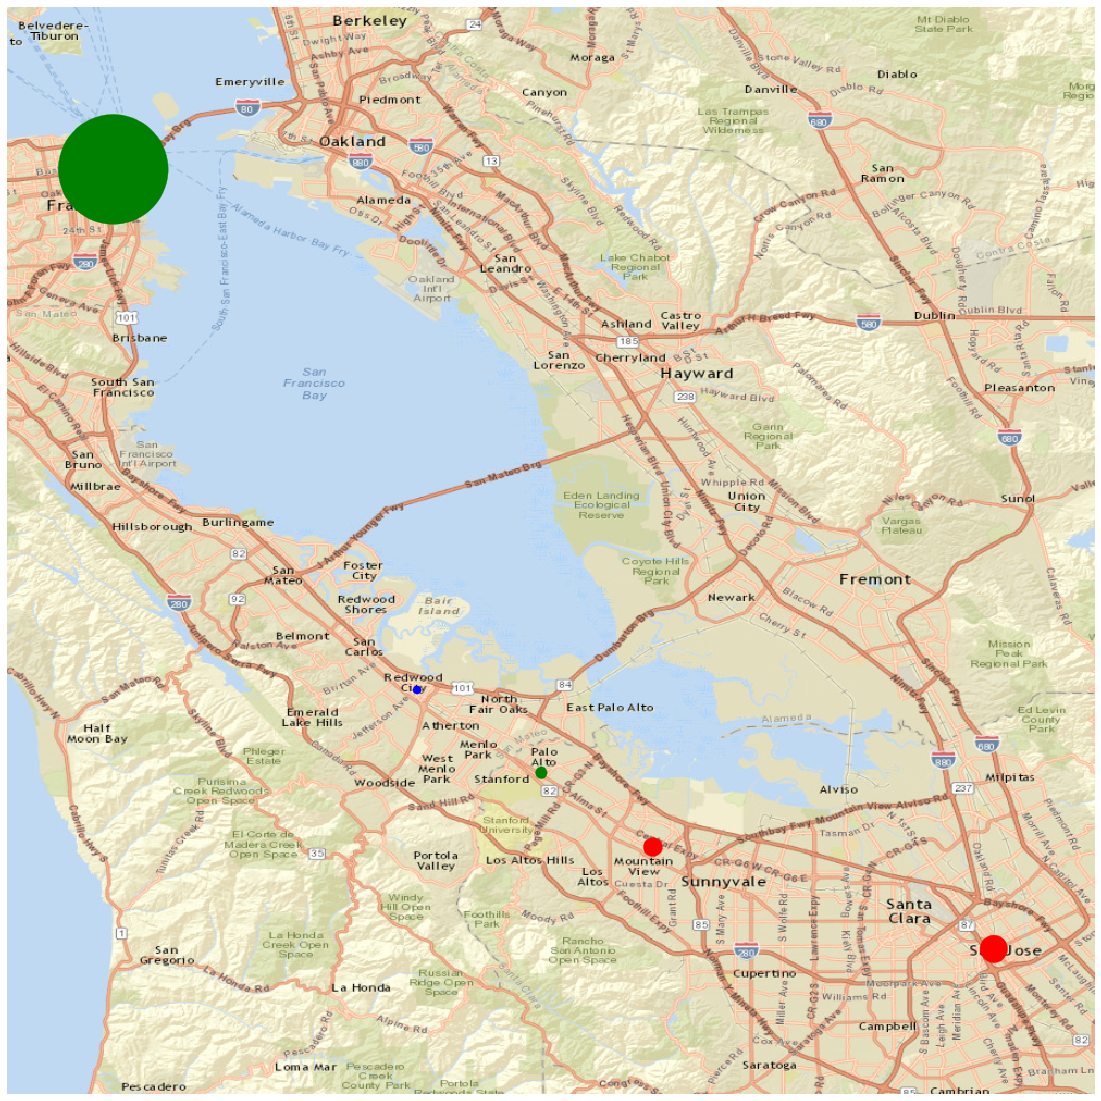

In [112]:
ciudades = [san_jose,
            san_fran,
            redwood,
            mt_view,
            palo_alto
           ]

lat_max, lon_max = station_bikes.max()[['lat','long']]
lat_min, lon_min = station_bikes.min()[['lat','long']]
lat, lon = (lat_max+lat_min)/2, (lon_max+lon_min)/2

offset = distancia_grados(35, 6371)

min_lat = lat - offset
min_lon = lon - offset
max_lat = lat + offset
max_lon = lon + offset

plt.figure(figsize = (20, 20))

mapa = Basemap(projection = 'merc',
               llcrnrlat = min_lat,
               llcrnrlon = min_lon,
               urcrnrlat = max_lat,
               urcrnrlon = max_lon,
               epsg = 4326,
               resolution = 'l'
              )

lons = []
lats = []
sizes = []

for ciudad in ciudades:
    lons.append(ciudad['long'].mean())
    lats.append(ciudad['lat'].mean())
    sizes.append(ciudad['count'].sum() / 50)

mapa.scatter(lons,
             lats,
             s = sizes,
             marker = 'o', 
             c = ['r','g','b']
            )

mapa.arcgisimage(service = 'World_Street_Map', xpixels = 1000, ypixels = 1000)

plt.show()